In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

Check for Cuda Availability

In [2]:
print(torch.cuda.get_device_name(0))
device = 'cuda'

NVIDIA GeForce GTX 1070


Load MNIST Dataset

In [3]:
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [4]:
# https://www.kaggle.com/datasets/eabdul/flying-vehicles
planes_train = r"data\planes\train"
planes_test = r"data\planes\test"

training_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(root=planes_train, transform=training_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

Retreive mean for normalization of plane data

In [5]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std
        
print(get_mean_and_std(train_loader))

(tensor([0.5810, 0.6154, 0.6458]), tensor([0.2069, 0.1940, 0.1976]))


In [6]:
mean = [0.5584, 0.5944, 0.6347]
std = [0.2177, 0.2015, 0.2082]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [7]:
plane_traindata = torchvision.datasets.ImageFolder(root=planes_train, transform=train_transforms)
plane_testdata = torchvision.datasets.ImageFolder(root=planes_test, transform=test_transforms)

plane_trainloader = torch.utils.data.DataLoader(plane_traindata, batch_size=32, shuffle=True)
planes_testloader = torch.utils.data.DataLoader(plane_testdata, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 0, 0, 0, 0, 0])


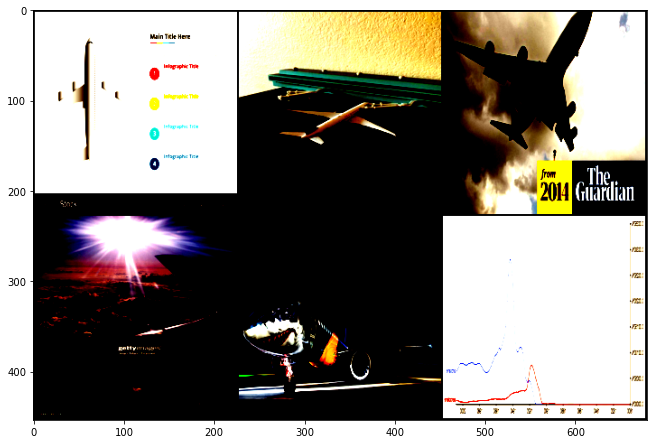

In [8]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

show_transformed_images(plane_traindata)

In [9]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
            ) 
            
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
            ) 
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
class AutoencoderConv(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [67]:
class AutoencoderConvPlanes(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [68]:
planemodel = AutoencoderConvPlanes().cuda()
mnistmodel = AutoencoderConv().cuda()

criterion = nn.MSELoss()
planeoptimizer = torch.optim.Adam(planemodel.parameters(), lr=1e-4, weight_decay=1e-5)  
mnistoptimizer = torch.optim.Adam(mnistmodel.parameters(), lr=1e-3, weight_decay=1e-5)  

In [69]:
def trainingLoop(loader, model, criterion, optimizer, num_epochs=10):
    outputs = []
    for epoch in range(num_epochs):
        for (img, _) in loader:
            # img = img.reshape(-1, 28*28).to(device) For Linear
            img = img.to(device)
            recon = model(img)
            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))
    return outputs

In [14]:
mnistout = trainingLoop(mnist_loader, mnistmodel, criterion, mnistoptimizer)  

Epoch:1, Loss:0.0091
Epoch:2, Loss:0.0054
Epoch:3, Loss:0.0044
Epoch:4, Loss:0.0038
Epoch:5, Loss:0.0034
Epoch:6, Loss:0.0031
Epoch:7, Loss:0.0033
Epoch:8, Loss:0.0029
Epoch:9, Loss:0.0030
Epoch:10, Loss:0.0032


In [70]:
planeout = trainingLoop(plane_trainloader, planemodel, criterion, planeoptimizer)

Epoch:1, Loss:1.1931
Epoch:2, Loss:0.9315
Epoch:3, Loss:0.7481
Epoch:4, Loss:0.4914
Epoch:5, Loss:0.6978
Epoch:6, Loss:0.6720
Epoch:7, Loss:0.5797
Epoch:8, Loss:0.5014
Epoch:9, Loss:0.6107
Epoch:10, Loss:0.7670


In [71]:
def outputLoop(outputs, num_epochs):
    for k in range(0, num_epochs):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = outputs[k][1].detach().cpu().numpy()
        recon = outputs[k][2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
            # item: 1, 28, 28
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1) # row_length + i + 1
            # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
            # item: 1, 28, 28
            plt.imshow(item[0])

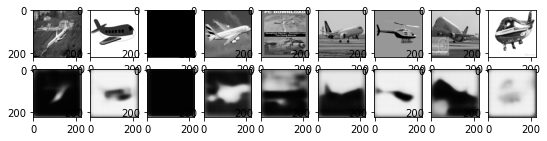

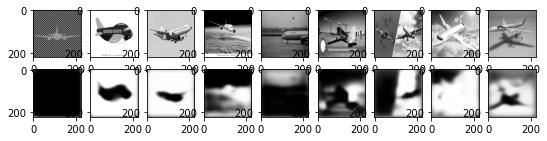

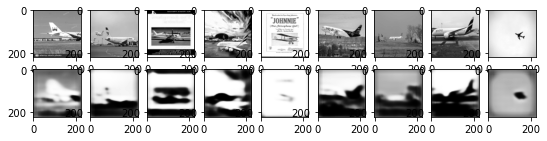

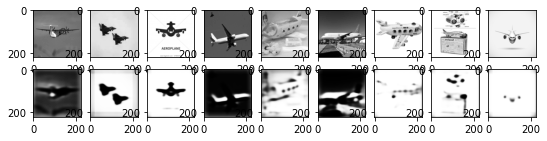

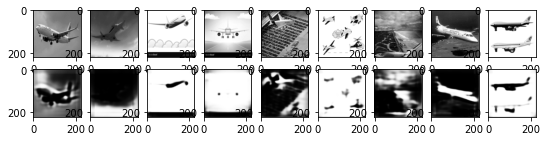

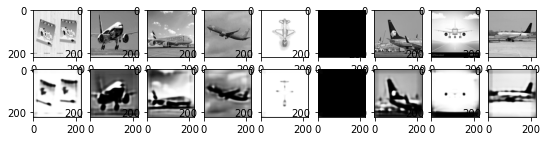

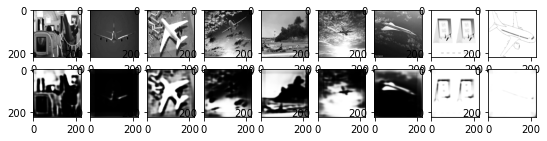

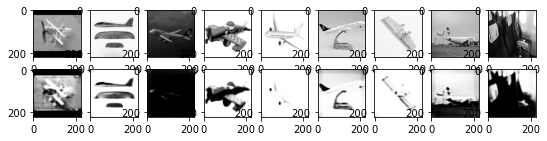

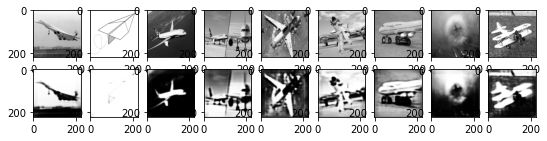

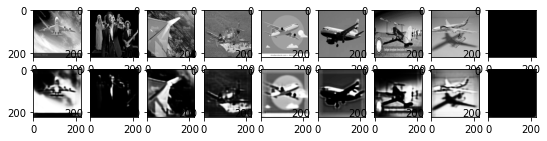

In [72]:
outputLoop(planeout, 10)

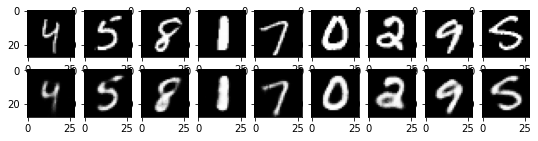

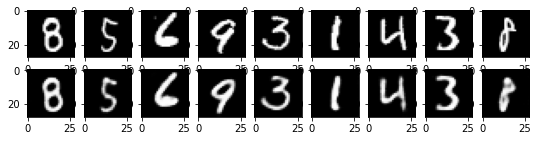

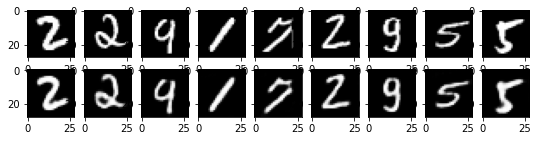

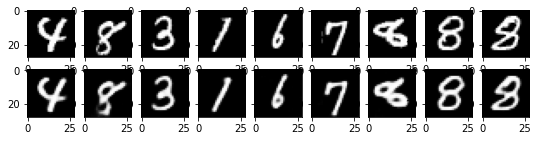

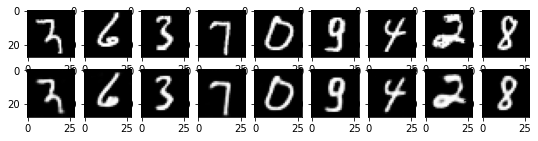

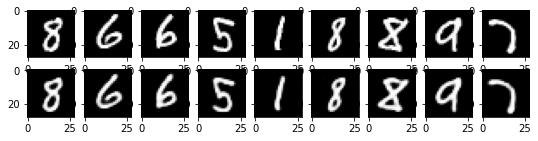

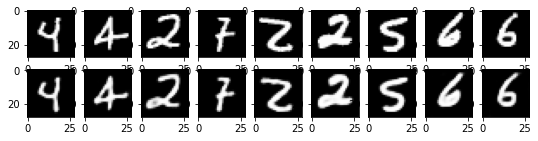

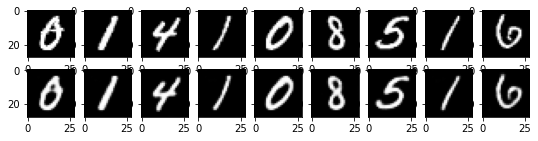

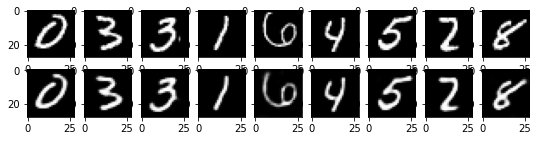

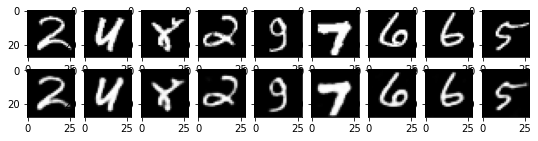

In [18]:
outputLoop(mnistout, 10)

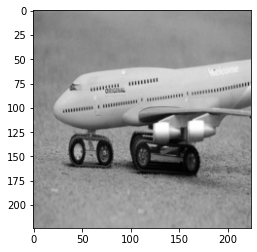

In [75]:
plt.imshow(planeout[8][1].detach().cpu().numpy()[6][0])

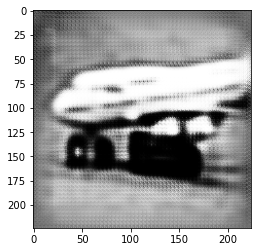

In [76]:
plt.imshow(planeout[8][2].detach().cpu().numpy()[6][0])

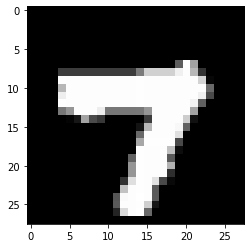

In [21]:
plt.imshow(mnistout[9][1].detach().cpu().numpy()[5][0])

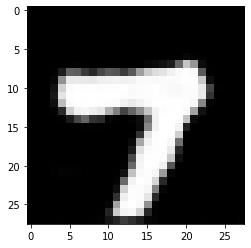

In [22]:
plt.imshow(mnistout[9][2].detach().cpu().numpy()[5][0])

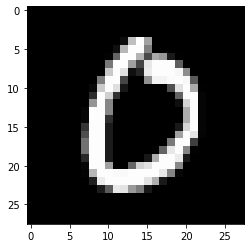

In [23]:
latent = 0
for (img, _) in mnist_loader:
    plt.imshow(img.detach().cpu().numpy()[0][0])
    
    latent = mnistmodel.encode(img.to(device))
    full = mnistmodel.decoder(latent)
    
    latent = [a[0][0] for a in latent.detach().cpu().numpy()[0]]
    break

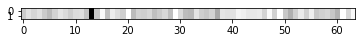

In [24]:
plt.imshow( [latent, latent] )

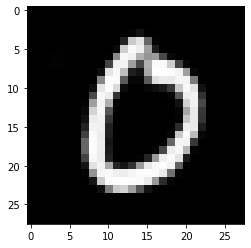

In [25]:
plt.imshow(full.detach().cpu().numpy()[0][0])

In [58]:
mnistlinear = AutoencoderLinear().cuda()
mnistoptimizerlinear = torch.optim.Adam(mnistlinear.parameters(), lr=1e-3, weight_decay=1e-5)  

In [59]:
def trainingLoopLinear(loader, model, criterion, optimizer, num_epochs=10):
    outputs = []
    for epoch in range(num_epochs):
        for (img, _) in loader:
            img = img.reshape(-1, 28*28).to(device) # For Linear
            img = img.to(device)
            recon = model(img)
            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))
    return outputs

In [60]:
mnistoutlinear = trainingLoopLinear(mnist_loader, mnistlinear, criterion, mnistoptimizerlinear)  

Epoch:1, Loss:0.0514
Epoch:2, Loss:0.0414
Epoch:3, Loss:0.0345
Epoch:4, Loss:0.0333
Epoch:5, Loss:0.0411
Epoch:6, Loss:0.0387
Epoch:7, Loss:0.0376
Epoch:8, Loss:0.0333
Epoch:9, Loss:0.0311
Epoch:10, Loss:0.0402


In [63]:
def outputLoopLinear(outputs, num_epochs):
    for k in range(0, num_epochs):
        plt.figure(figsize=(9, 2))
        # plt.gray()
        imgs = outputs[k][1].detach().cpu().numpy()
        recon = outputs[k][2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
            # item: 1, 28, 28
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1) # row_length + i + 1
            item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
            # item: 1, 28, 28
            plt.imshow(item[0])

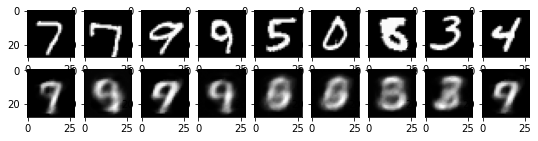

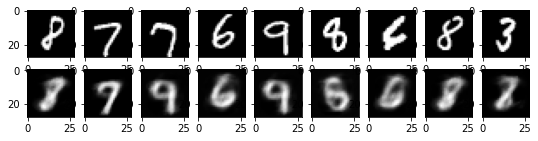

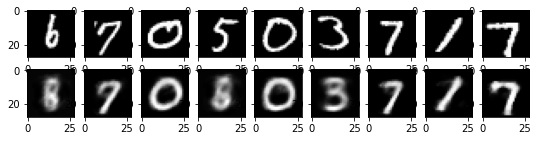

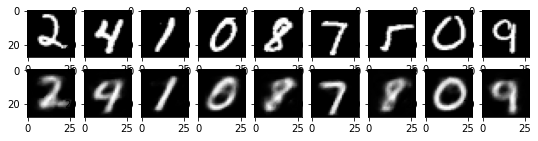

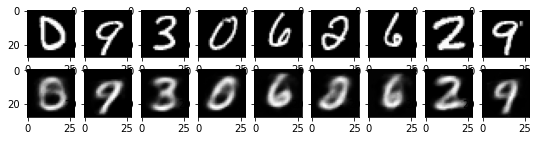

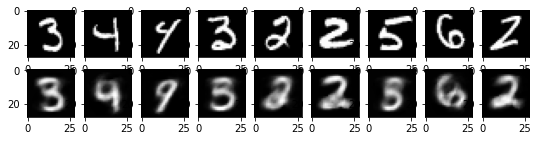

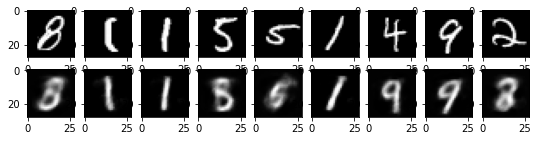

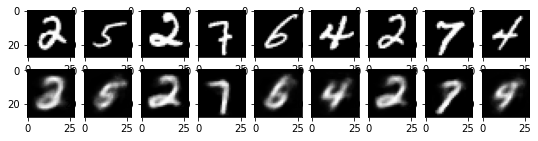

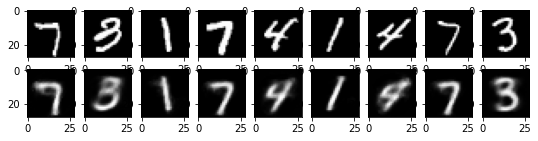

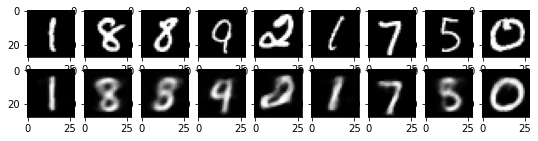

In [64]:
outputLoopLinear(mnistoutlinear, 10)